# Regime Prediction with Machine Learning

Business cycle describes the rise and fall in the growth of the economy that occurs over time.

Each business cyle has two turning points trough (or bottom) and peak. Expansion is measured from the trough of the previous business cycle to the peak of the current cycle, while recession is measured from the peak to the trough.

A representation of business cycles is shown in the figure below:
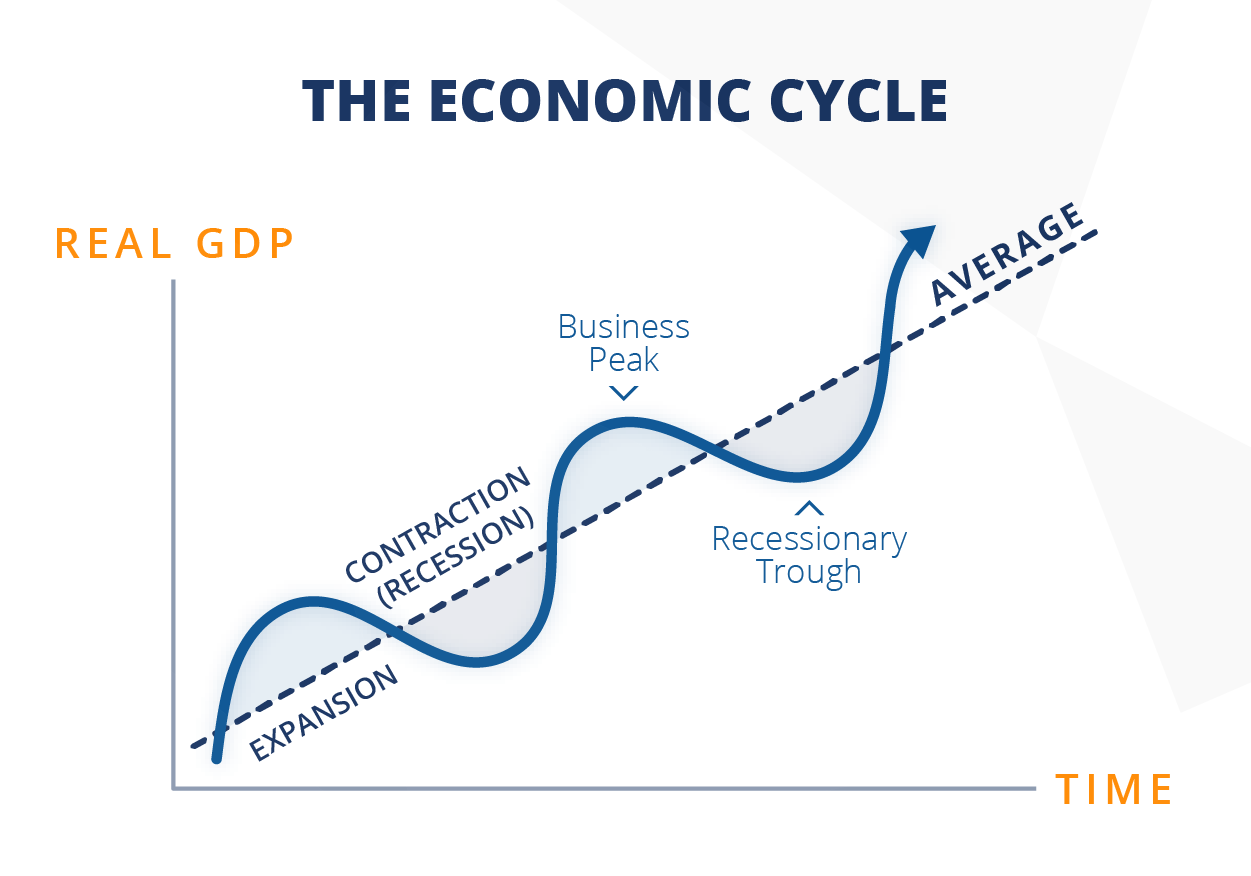

In the United States (US), the Business Cycle Dating Committee of the National Bureau of Economic Research (NBER) determines the dates for business cycles. The turning points are determined by considering monthly growth indicators of the economy such as industrial production, employment, real income. The main focus of business cycle analysis is to analyze why economy goes through contraction and expansion periods.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime as dt
import cvxpy as cp

from scipy.optimize import minimize
from pandas_datareader import data 
import yfinance as yf
from statsmodels.tsa.stattools import adfuller #to check unit root in time series 

import xgboost as xgb

from sklearn import model_selection, preprocessing
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV, TimeSeriesSplit
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# using seaborn style (type plt.style.available to see available styles)
plt.style.use("seaborn-dark")

## Getting the macroeconomics data:

For our analysis we will use a large macroeconomic database from FRED St. Louis designed by McCracken and Ng (2015). It involves 128 macroeconomic monthly time series over the period 1959-2022. The data is organized into 8 categories:

- Output and income
- Labor market
- Housing
- Consumption, orders and inventories
- Money and credit
- Interest and exchange rates
- Prices
- Stock market.

In [4]:
bigmacro = pd.read_csv("current.csv")
bigmacro = bigmacro.rename(columns={'sasdate':'Date'})
bigmacro = bigmacro.set_index(keys="Date")
bigmacro = bigmacro.drop('Transform:')
bigmacro

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
Date,,,,,,,,,,,,,,,,,,,,,
1/1/1959,2442.158,2293.2,17.272,2.922664e+05,18235.77392,22.0151,23.3984,22.2848,31.5847,18.6861,...,17.791,11.326,2.13,2.45,2.04,NaN,6476.00,12298.00,84.2043,NaN
2/1/1959,2451.778,2301.5,17.452,2.944247e+05,18369.56308,22.4463,23.7142,22.4778,31.8164,18.7842,...,17.798,11.343,2.14,2.46,2.05,NaN,6476.00,12298.00,83.5280,NaN
3/1/1959,2467.594,2318.5,17.617,2.934187e+05,18523.05762,22.7696,23.8577,22.5882,31.8164,19.1520,...,17.785,11.363,2.15,2.45,2.07,NaN,6508.00,12349.00,81.6405,NaN
4/1/1959,2483.671,2334.9,17.553,2.993228e+05,18534.46600,23.2547,24.2022,22.9191,32.3184,19.2746,...,17.796,11.403,2.16,2.47,2.08,NaN,6620.00,12484.00,81.8099,NaN
5/1/1959,2498.026,2350.4,17.765,3.013643e+05,18679.66354,23.6050,24.4032,23.1398,32.4728,19.6670,...,17.777,11.421,2.17,2.48,2.08,95.3,6753.00,12646.00,80.7315,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3/1/2022,17665.439,14442.9,125.880,1.549969e+06,669958.00000,103.7286,103.7781,104.1434,104.7319,113.6075,...,112.165,128.206,27.53,31.72,24.74,59.4,369346.54,747716.57,5818.0494,26.9368
4/1/2022,17706.513,14490.2,126.202,1.552487e+06,674719.00000,104.5224,104.9900,105.6544,106.2488,116.8381,...,111.803,128.754,27.60,31.75,24.82,65.2,369872.34,747272.46,5817.1627,24.4850
5/1/2022,17708.689,14512.0,125.788,1.538267e+06,673852.00000,104.5729,104.6259,105.1021,105.5403,113.7636,...,113.157,129.296,27.84,32.14,24.95,58.4,370637.86,747394.09,5803.3039,29.1728


In [5]:
# manually put the dates in datetime format. Note that directly using pd.to_datetime does not work fine 
# because up to 1968 (/68 in the index) year are parsed as years of the 21st century, i.g., 1/1/59 -> 2059-01.
years  = np.arange(1959,2022+1,1)
months = np.arange(1,12+1,1)
strdate = []
for y in years:
    for m in months:
        strdate.append( str(y) + "-" + str(m)  )
        if y==2022 and m==7:
            break
# now parse dates
bigmacro.index = pd.to_datetime(strdate, format="%Y-%m", infer_datetime_format=True).to_period("M") 
bigmacro.index.rename("Date", inplace=True)
bigmacro

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
Date,,,,,,,,,,,,,,,,,,,,,
1959-01,2442.158,2293.2,17.272,2.922664e+05,18235.77392,22.0151,23.3984,22.2848,31.5847,18.6861,...,17.791,11.326,2.13,2.45,2.04,NaN,6476.00,12298.00,84.2043,NaN
1959-02,2451.778,2301.5,17.452,2.944247e+05,18369.56308,22.4463,23.7142,22.4778,31.8164,18.7842,...,17.798,11.343,2.14,2.46,2.05,NaN,6476.00,12298.00,83.5280,NaN
1959-03,2467.594,2318.5,17.617,2.934187e+05,18523.05762,22.7696,23.8577,22.5882,31.8164,19.1520,...,17.785,11.363,2.15,2.45,2.07,NaN,6508.00,12349.00,81.6405,NaN
1959-04,2483.671,2334.9,17.553,2.993228e+05,18534.46600,23.2547,24.2022,22.9191,32.3184,19.2746,...,17.796,11.403,2.16,2.47,2.08,NaN,6620.00,12484.00,81.8099,NaN
1959-05,2498.026,2350.4,17.765,3.013643e+05,18679.66354,23.6050,24.4032,23.1398,32.4728,19.6670,...,17.777,11.421,2.17,2.48,2.08,95.3,6753.00,12646.00,80.7315,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03,17665.439,14442.9,125.880,1.549969e+06,669958.00000,103.7286,103.7781,104.1434,104.7319,113.6075,...,112.165,128.206,27.53,31.72,24.74,59.4,369346.54,747716.57,5818.0494,26.9368
2022-04,17706.513,14490.2,126.202,1.552487e+06,674719.00000,104.5224,104.9900,105.6544,106.2488,116.8381,...,111.803,128.754,27.60,31.75,24.82,65.2,369872.34,747272.46,5817.1627,24.4850
2022-05,17708.689,14512.0,125.788,1.538267e+06,673852.00000,104.5729,104.6259,105.1021,105.5403,113.7636,...,113.157,129.296,27.84,32.14,24.95,58.4,370637.86,747394.09,5803.3039,29.1728


In [6]:
#Lets drop NAN rows at the empty month of 7
bigmacro = bigmacro.drop('2022-07')
bigmacro

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
Date,,,,,,,,,,,,,,,,,,,,,
1959-01,2442.158,2293.2,17.272,2.922664e+05,18235.77392,22.0151,23.3984,22.2848,31.5847,18.6861,...,17.791,11.326,2.13,2.45,2.04,NaN,6476.00,12298.00,84.2043,NaN
1959-02,2451.778,2301.5,17.452,2.944247e+05,18369.56308,22.4463,23.7142,22.4778,31.8164,18.7842,...,17.798,11.343,2.14,2.46,2.05,NaN,6476.00,12298.00,83.5280,NaN
1959-03,2467.594,2318.5,17.617,2.934187e+05,18523.05762,22.7696,23.8577,22.5882,31.8164,19.1520,...,17.785,11.363,2.15,2.45,2.07,NaN,6508.00,12349.00,81.6405,NaN
1959-04,2483.671,2334.9,17.553,2.993228e+05,18534.46600,23.2547,24.2022,22.9191,32.3184,19.2746,...,17.796,11.403,2.16,2.47,2.08,NaN,6620.00,12484.00,81.8099,NaN
1959-05,2498.026,2350.4,17.765,3.013643e+05,18679.66354,23.6050,24.4032,23.1398,32.4728,19.6670,...,17.777,11.421,2.17,2.48,2.08,95.3,6753.00,12646.00,80.7315,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02,17724.106,14484.3,125.552,1.569743e+06,662321.00000,102.9981,103.4073,103.6360,104.4925,110.2858,...,109.082,127.593,27.42,31.60,24.56,62.8,374193.90,753730.65,5810.8647,26.1429
2022-03,17665.439,14442.9,125.880,1.549969e+06,669958.00000,103.7286,103.7781,104.1434,104.7319,113.6075,...,112.165,128.206,27.53,31.72,24.74,59.4,369346.54,747716.57,5818.0494,26.9368
2022-04,17706.513,14490.2,126.202,1.552487e+06,674719.00000,104.5224,104.9900,105.6544,106.2488,116.8381,...,111.803,128.754,27.60,31.75,24.82,65.2,369872.34,747272.46,5817.1627,24.4850


Consistent with the previous works in the literature, we use business cycle dating chronology provided by NBER which involves dates when recession began and ended in US economy. According to NBER's statistics we have 9 recession periods in our dataset where duration is changing from 2 to 18 months.

We represent regimes as Normal and Recession in our dataset.

In [7]:
# load regimes classifications
recession_periods = pd.read_csv('Recession_Periods.csv')["Regime"]
# and insert them into bigmacro dataframe
bigmacro.insert(loc=0, column="Regime", value=recession_periods.values)
bigmacro

,Regime,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
Date,,,,,,,,,,,,,,,,,,,,,
1959-01,Normal,2442.158,2293.2,17.272,2.922664e+05,18235.77392,22.0151,23.3984,22.2848,31.5847,...,17.791,11.326,2.13,2.45,2.04,NaN,6476.00,12298.00,84.2043,NaN
1959-02,Normal,2451.778,2301.5,17.452,2.944247e+05,18369.56308,22.4463,23.7142,22.4778,31.8164,...,17.798,11.343,2.14,2.46,2.05,NaN,6476.00,12298.00,83.5280,NaN
1959-03,Normal,2467.594,2318.5,17.617,2.934187e+05,18523.05762,22.7696,23.8577,22.5882,31.8164,...,17.785,11.363,2.15,2.45,2.07,NaN,6508.00,12349.00,81.6405,NaN
1959-04,Normal,2483.671,2334.9,17.553,2.993228e+05,18534.46600,23.2547,24.2022,22.9191,32.3184,...,17.796,11.403,2.16,2.47,2.08,NaN,6620.00,12484.00,81.8099,NaN
1959-05,Normal,2498.026,2350.4,17.765,3.013643e+05,18679.66354,23.6050,24.4032,23.1398,32.4728,...,17.777,11.421,2.17,2.48,2.08,95.3,6753.00,12646.00,80.7315,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02,Normal,17724.106,14484.3,125.552,1.569743e+06,662321.00000,102.9981,103.4073,103.6360,104.4925,...,109.082,127.593,27.42,31.60,24.56,62.8,374193.90,753730.65,5810.8647,26.1429
2022-03,Normal,17665.439,14442.9,125.880,1.549969e+06,669958.00000,103.7286,103.7781,104.1434,104.7319,...,112.165,128.206,27.53,31.72,24.74,59.4,369346.54,747716.57,5818.0494,26.9368
2022-04,Normal,17706.513,14490.2,126.202,1.552487e+06,674719.00000,104.5224,104.9900,105.6544,106.2488,...,111.803,128.754,27.60,31.75,24.82,65.2,369872.34,747272.46,5817.1627,24.4850


In [8]:
bigmacro["Regime"].value_counts()

Normal       666
Recession     96
Name: Regime, dtype: int64

In our dataset we have total 666 months (devils number) of normal regimes and 96 months of recession regimes.

In [9]:
# dates of normal and recession regimes
normal_dates     = bigmacro[bigmacro["Regime"] == "Normal"].index
recessions_dates = bigmacro[bigmacro["Regime"] == "Recession"].index

In [10]:
# find indices of recession regimes 
rec_idx = np.zeros_like(recessions_dates)
rec_idx[0] = 1
for i, date in enumerate(recessions_dates):
    prev_date = date - 1
    if prev_date not in recessions_dates:
        rec_idx[i] = 1
        rec_idx[i-1] = 1
rec_idx = np.array([False if i==0 else True for i in rec_idx])
recessions_dates[rec_idx]

PeriodIndex(['1960-04', '1961-01', '1969-12', '1970-10', '1973-11', '1975-02',
             '1980-01', '1980-06', '1981-07', '1982-10', '1990-07', '1991-02',
             '2001-03', '2001-10', '2007-12', '2009-05', '2020-02', '2020-04'],
            dtype='period[M]', name='Date')

Lets check if our findings of regimes can be overlapped on the stock market. For this we use S&P 500 index to overlap our findings.

In [20]:
# loading the S&P500 index for the current set of dates that we have 
ticker = "^GSPC"
sp500 = yf.download(ticker)
sp500 = sp500['1959-01-01': '2022-06-01']
sp500.insert(loc=0, column="idx", value=np.arange(0,sp500.shape[0]))
sp500 = sp500[["idx","Adj Close"]]
sp500

[*********************100%***********************]  1 of 1 completed


,idx,Adj Close
Date,,
1959-01-02,0,55.439999
1959-01-05,1,55.660000
1959-01-06,2,55.590000
1959-01-07,3,54.889999
1959-01-08,4,55.400002
...,...,...
2022-05-25,15959,3978.729980
2022-05-26,15960,4057.840088
2022-05-27,15961,4158.240234


In [21]:
# S&P500 are daily data, then we have to find the right recession dates 
rr = []
for date in recessions_dates[rec_idx]:
    rr.append( sp500[str(date)].iloc[0,:]["idx"] ) 
rr = np.array(rr)
rr

array([  316.,   505.,  2720.,  2932.,  3711.,  4027.,  5268.,  5373.,
        5646.,  5963.,  7922.,  8071., 10616., 10760., 12314., 12669.,
       15376., 15417.])

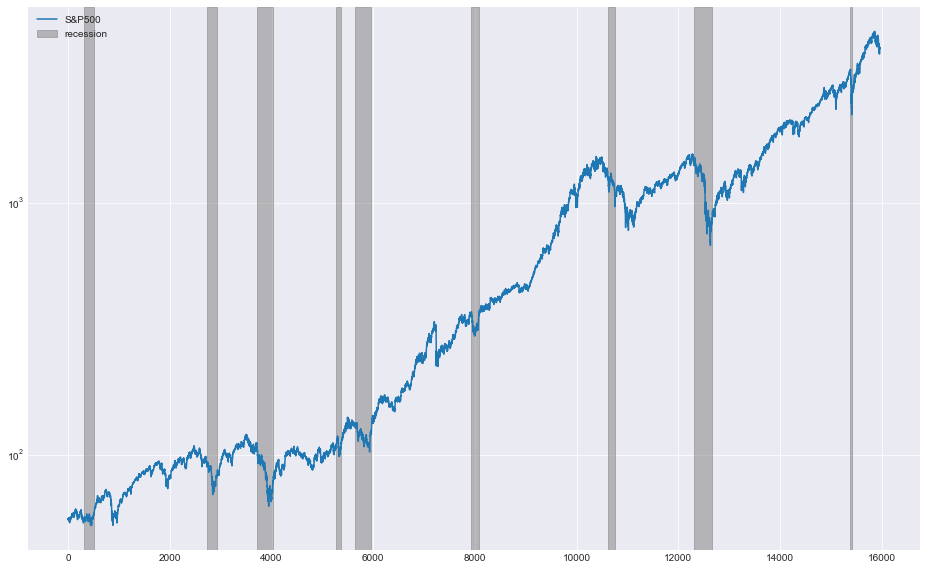

In [27]:
# index of starting recession periods
x1 = np.array(rr)[:-1:2]
# index of ending recession periods
x2 = np.array(rr)[1::2]

fig, ax = plt.subplots(1,1,figsize=(16,10))
ax.semilogy(sp500["Adj Close"].values, label="S&P500")
ax.axvspan(x1[0], x2[0], alpha=0.5, color='gray', label="recession")
for i in range(1,len(x1)):
    ax.axvspan(x1[i], x2[i], alpha=0.5, color='gray')
ax.legend()
ax.grid()
plt.show()

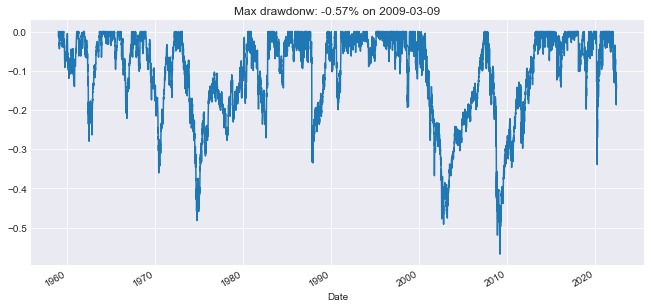

In [23]:
# S&P Drawdowns
previous_peaks = sp500["Adj Close"].cummax()
drawdowns      = (sp500["Adj Close"] - previous_peaks ) / previous_peaks
drawdowns.plot(grid=True, figsize=(11,5), title="Max drawdonw: {:.2f}% on {}".format(drawdowns.min(),str(drawdowns.idxmin()).split()[0]))
plt.show()

We can see there is a visual overlap between recession dating and drawdowns in the stock index.

## Preprocess the dataset:

We will follow the steps below to clean data and make it ready for feature selection process.
- Remove the variables with missing observations
- Add lags of the variables as additional features
- Test stationarity of time series
- Standardize the dataset

In [28]:
# compute the NaN (missing values) per columns and eliminate columns with more than 10 missing values
nan_per_col = bigmacro.isnull().sum()
cols_tobe_removed = nan_per_col[ nan_per_col > 10 ].index
bigmacro = bigmacro.drop(columns=cols_tobe_removed, axis=1)

# and now remove those row containing Nan (i.e. belonging to those columns with less than 10 NaNs)
bigmacro = bigmacro.dropna(axis=0)
bigmacro.shape

(759, 118)

In [29]:
for col in bigmacro.columns[1:]:
    for n in [3,6,9,12,18]:
        bigmacro['{} {}M lag'.format(col, n)] = bigmacro[col].shift(n).ffill().values
        
# 1 month ahead prediction
bigmacro["Regime"] = bigmacro["Regime"].shift(-1)

# remove NaN on rows
bigmacro = bigmacro.dropna(axis=0)
bigmacro.head()

,Regime,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DTCTHFNM 3M lag,DTCTHFNM 6M lag,DTCTHFNM 9M lag,DTCTHFNM 12M lag,DTCTHFNM 18M lag,INVEST 3M lag,INVEST 6M lag,INVEST 9M lag,INVEST 12M lag,INVEST 18M lag
Date,,,,,,,,,,,,,,,,,,,,,
1960-07,Recession,2577.579,2421.7,18.231,293071.1233,18801.00720,23.2008,24.8625,23.7741,33.4381,...,14413.0,14063.0,13804.0,13199.0,12298.0,71.4718,75.4515,76.2235,78.9984,84.2043
1960-08,Recession,2573.388,2415.5,18.213,292706.2447,18865.30897,23.1738,24.8051,23.7741,33.5154,...,14559.0,14144.0,13889.0,13471.0,12298.0,71.6858,73.3363,75.8793,77.3045,83.5280
1960-09,Recession,2576.666,2416.2,18.300,297445.2652,18847.67784,22.9313,24.6042,23.6362,33.3609,...,14816.0,14239.0,14058.0,13657.0,12349.0,71.1864,71.5296,76.1711,76.8926,81.6405
1960-10,Recession,2584.282,2423.8,18.389,291831.4764,19013.61788,22.9044,24.7477,23.7465,33.7084,...,15028.0,14413.0,14063.0,13804.0,12484.0,73.0020,71.4718,75.4515,76.2235,81.8099
1960-11,Recession,2573.347,2409.9,18.325,288986.8774,18741.89106,22.5810,24.4893,23.4707,33.0906,...,15208.0,14559.0,14144.0,13889.0,12646.0,73.0803,71.6858,73.3363,75.8793,80.7315


In [30]:
bigmacro.shape

(740, 703)

## Looking for stationarity:

Now, test the stationarity of the series using the Augmented Dickey-Fuller unit root Test. We will use the adfuller method function from statsmodels module in Python.

The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, that is, the time series in NOT stationary, with the alternative that there is no unit root (i.e., the time series is stationary).

If the p-value is above a critical size (a threshold, a significance level), then we cannot reject that the series is not stationarity (the time series is therefore not stationary).

If a series in our dataset is not stationary we replace it with first-order difference in order to make it stationary:

In [31]:
significance_level = 0.01 
for col in bigmacro.columns[1:]:
    p_value_adf = adfuller( bigmacro[col] )[1] # 1 to select the p-value
    if p_value_adf > significance_level:
        bigmacro[col] = bigmacro[col].diff()
        
bigmacro = bigmacro.dropna(axis=0)  

In [32]:
# repeat
for col in bigmacro.columns[1:]:
    p_value_adf = adfuller( bigmacro[col] )[1]
    if p_value_adf > significance_level:
        bigmacro[col] = bigmacro[col].diff()

bigmacro = bigmacro.dropna(axis=0)  

In [33]:
# repeat 
print("Remaining non stationary series:")
for col in bigmacro.columns[1:]:
    p_value_adf = adfuller( bigmacro[col] )[1] # 1 to select the p-value
    if p_value_adf > significance_level:
        print(col)
bigmacro = bigmacro.dropna(axis=0)  

Remaining non stationary series:
M1SL 12M lag
M1SL 18M lag
M2SL 18M lag
CUSR0000SAS 18M lag


In [35]:
# repeat
for col in bigmacro.columns[1:]:
    p_value_adf = adfuller( bigmacro[col] )[1]
    if p_value_adf > significance_level:
        bigmacro[col] = bigmacro[col].diff()

bigmacro = bigmacro.dropna(axis=0) 

In [36]:
# repeat 
print("Remaining non stationary series:")
for col in bigmacro.columns[1:]:
    p_value_adf = adfuller( bigmacro[col] )[1] # 1 to select the p-value
    if p_value_adf > significance_level:
        print(col)
bigmacro = bigmacro.dropna(axis=0)  

Remaining non stationary series:
M1SL 18M lag


In [37]:
# repeat
for col in bigmacro.columns[1:]:
    p_value_adf = adfuller( bigmacro[col] )[1]
    if p_value_adf > significance_level:
        bigmacro[col] = bigmacro[col].diff()

bigmacro = bigmacro.dropna(axis=0) 

In [38]:
# repeat 
print("Remaining non stationary series:")
for col in bigmacro.columns[1:]:
    p_value_adf = adfuller( bigmacro[col] )[1] # 1 to select the p-value
    if p_value_adf > significance_level:
        print(col)
bigmacro = bigmacro.dropna(axis=0)  

Remaining non stationary series:


Now that we have made our dataset stationary. Lets move on to scaling the data using stadanrd scaler function from sklearn library.

In [39]:
features  = bigmacro.drop(["Regime"],axis=1)
col_names = features.columns

# Standardize
scaler = StandardScaler()
scaler.fit(features)
standardized_features = scaler.transform(features)

df = pd.DataFrame(data=standardized_features, columns=col_names)
df.insert(loc=0, column="Regime", value=bigmacro["Regime"].values )
df.index = bigmacro.index
df.shape

(736, 703)

In [40]:
df

,Regime,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DTCTHFNM 3M lag,DTCTHFNM 6M lag,DTCTHFNM 9M lag,DTCTHFNM 12M lag,DTCTHFNM 18M lag,INVEST 3M lag,INVEST 6M lag,INVEST 9M lag,INVEST 12M lag,INVEST 18M lag
Date,,,,,,,,,,,,,,,,,,,,,
1960-11,Recession,-0.151630,-0.518490,-0.365308,-0.462605,-0.071603,-0.608936,-0.528095,-0.510566,-0.893067,...,-0.083918,-0.088157,-0.094499,-0.092373,-0.082999,-0.112946,0.011711,-0.093965,0.010881,-0.085295
1960-12,Recession,-0.156233,-0.521921,-0.645313,0.056605,0.019935,-0.760321,-0.652403,-0.547164,-0.410338,...,-0.094716,-0.076847,-0.093072,-0.083811,-0.070966,0.046767,-0.049769,0.012814,0.030467,-0.066692
1961-01,Normal,0.012643,0.078377,-0.175738,-1.222083,0.022588,-0.116548,-0.196464,-0.217912,-0.458473,...,-0.102866,-0.081432,-0.085023,-0.100527,-0.071680,0.052810,0.139213,0.103070,-0.073250,0.143078
1961-02,Normal,-0.051178,-0.276656,-0.137477,0.174736,-0.014558,-0.192170,-0.113592,-0.144848,0.120652,...,-0.099097,-0.084693,-0.087876,-0.092781,-0.071782,-0.046568,-0.113663,0.010515,-0.097438,-0.132923
1961-03,Normal,-0.047887,-0.075986,0.139051,0.513928,0.040332,0.034978,0.010715,-0.108250,-0.120650,...,-0.089215,-0.095493,-0.076566,-0.091354,-0.080552,-0.007995,0.047643,-0.051218,0.009848,0.075936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11,Normal,-0.018440,0.112679,-0.427918,0.032260,-0.985286,0.690137,0.887510,0.645198,0.643765,...,-0.051420,0.206206,-0.386399,0.173961,-0.238585,0.798452,0.600802,0.676605,2.774640,-5.176161
2021-12,Normal,-0.148793,-0.242354,-3.335803,-1.142836,-2.270508,-0.438715,-0.430353,-0.243372,-0.540616,...,0.110021,0.105103,0.645033,-0.063662,0.295166,0.554536,-2.536563,1.262646,-2.658259,7.079197
2022-01,Normal,-0.518839,-0.696864,2.620840,1.738220,4.397359,0.390037,0.942661,1.144446,1.880032,...,-0.392524,-0.123526,0.694540,0.446240,0.338730,2.984342,-2.253740,-0.294013,0.963980,-0.908276


Lets create labels for machine learning models as regime=recession -> 1, regime=normal -> 0

In [41]:
label = df["Regime"].apply(lambda regime: 0 if regime == "Normal" else 1)
df.insert(loc=1, column="label", value=label.values)
df

,Regime,label,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,...,DTCTHFNM 3M lag,DTCTHFNM 6M lag,DTCTHFNM 9M lag,DTCTHFNM 12M lag,DTCTHFNM 18M lag,INVEST 3M lag,INVEST 6M lag,INVEST 9M lag,INVEST 12M lag,INVEST 18M lag
Date,,,,,,,,,,,,,,,,,,,,,
1960-11,Recession,1,-0.151630,-0.518490,-0.365308,-0.462605,-0.071603,-0.608936,-0.528095,-0.510566,...,-0.083918,-0.088157,-0.094499,-0.092373,-0.082999,-0.112946,0.011711,-0.093965,0.010881,-0.085295
1960-12,Recession,1,-0.156233,-0.521921,-0.645313,0.056605,0.019935,-0.760321,-0.652403,-0.547164,...,-0.094716,-0.076847,-0.093072,-0.083811,-0.070966,0.046767,-0.049769,0.012814,0.030467,-0.066692
1961-01,Normal,0,0.012643,0.078377,-0.175738,-1.222083,0.022588,-0.116548,-0.196464,-0.217912,...,-0.102866,-0.081432,-0.085023,-0.100527,-0.071680,0.052810,0.139213,0.103070,-0.073250,0.143078
1961-02,Normal,0,-0.051178,-0.276656,-0.137477,0.174736,-0.014558,-0.192170,-0.113592,-0.144848,...,-0.099097,-0.084693,-0.087876,-0.092781,-0.071782,-0.046568,-0.113663,0.010515,-0.097438,-0.132923
1961-03,Normal,0,-0.047887,-0.075986,0.139051,0.513928,0.040332,0.034978,0.010715,-0.108250,...,-0.089215,-0.095493,-0.076566,-0.091354,-0.080552,-0.007995,0.047643,-0.051218,0.009848,0.075936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11,Normal,0,-0.018440,0.112679,-0.427918,0.032260,-0.985286,0.690137,0.887510,0.645198,...,-0.051420,0.206206,-0.386399,0.173961,-0.238585,0.798452,0.600802,0.676605,2.774640,-5.176161
2021-12,Normal,0,-0.148793,-0.242354,-3.335803,-1.142836,-2.270508,-0.438715,-0.430353,-0.243372,...,0.110021,0.105103,0.645033,-0.063662,0.295166,0.554536,-2.536563,1.262646,-2.658259,7.079197
2022-01,Normal,0,-0.518839,-0.696864,2.620840,1.738220,4.397359,0.390037,0.942661,1.144446,...,-0.392524,-0.123526,0.694540,0.446240,0.338730,2.984342,-2.253740,-0.294013,0.963980,-0.908276


Now we can make this a classification problem. As we have two binary outcomes that we want to predict with certain variables. Here we will summarize our approach to predict recessions with machine learning algorithms:

- We will perform feature selection before making our forecasts: regularized logistic regression will be used

- Separate dataset into training and validation (test) sets: the period 1960-2000 is selected for training and the period over 2000-2022 is kept for validation

- Evaluate performances on training dataset with cross validation (CV). Since we have time series structure we will use a special type of CV function in Python, TimeSeriesSplit. Then we use the Receiver operating characteristic (ROC) as scoring metric in our models. Related Python functions for this metric are roc_auc_score and roc_curve

- Select the best performing models based on average accuracy and standard deviation of the CV results. We take logistic regression as a benchmark model since this is the traditional method has been used to approach this problem

- Make predictions on the test set with selected models. That is, we first use GridSearchCV for the selected model on training dataset to find best combination of parameters for the model. Then we evaluate the model on test set and report accuracy metrics and feature importance results.

In [42]:
# Separate the features from the targets
df_targets  = df["label"].values
df_features = df.iloc[:,2:]
df_features.shape, df_targets.shape

((736, 702), (736,))

## Feature selection using logistic regression:

Logistic regression is the most commonly used statistical model for binary classification. It uses the logit model of relating log-odds of the dependent variable linearly with the predictor (explanatory) variables to learn a form of the following logistic function that is used to separate instances of the two different classes.

$ \mathbb{P} (y=1 | x) = h_\beta (x) = \frac{1}{(1 + \exp^-(\beta_0 + \beta_1 x))}  $ 

where $ \beta_0 $ is the intercept and $ \beta$  is the vector of trained weights. The function returns a probability measure of which class a new instance is given its features. This measure is then used to make the final classification with some probability threshold, normally, a value equal to 0.5.

The specific logistic function is learned through gradient descent which focuses on minimizing error calculated through some cost function. A typical approach is to use the following maximum-likelihood estimator to minimize error in predicted probabilities:

$ J (\beta) = - \frac {1}{N} \Sigma y_i log(h_\beta(x_i)) + (1-y_i) log(1-h_\beta (x_i))  $

where $N$ is the number of observations, $h_\beta(x)$ is the function above, and $ y_i $ is the predicted class. A $L^1$ regularization term:

$ \lambda \Sigma | \beta_i|$

with $\lambda$ being a regularization parameter is often added to the cost function to prevent overfitting by penalizing large coefficients.

In [157]:
scoring = "roc_auc"
kfold   = model_selection.TimeSeriesSplit(n_splits=4)
seed    = 8
max_iter = 10000
penalty = "l1"

X = df_features
y = df_targets

In [158]:
# create regularization hyperparameter space
C = 1 / np.array([0.00000001, 0.00000005, 0.0000001, 0.0000005, 0.000001, 0.000005, 0.00001, 0.00005, 
                  0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000])

# create hyperparameter options
#hyperparameters = 

# select the estimator
model = LogisticRegression(max_iter=max_iter, penalty=penalty, solver='liblinear')

# perform grid-searchCV to tune the pearameters
lr_gscv = GridSearchCV(estimator=model, param_grid= dict(C=C), 
                       cv=kfold, scoring=scoring).fit(X = X, y = y)

# select the best estimator 
lr_gscv_best = lr_gscv.best_estimator_
lr_gscv_best

LogisticRegression(C=0.1, max_iter=10000, penalty='l1', solver='liblinear')

In [159]:
# now that we have the best estimator do the penalized linear regression 
lr_l1 = LogisticRegression(C=lr_gscv_best.C, max_iter=lr_gscv_best.max_iter, penalty=penalty,solver='liblinear').fit(X=X, y=y)

In [160]:
# features selection 
model = SelectFromModel(lr_l1, prefit=True)

In [161]:
# features (columns) that have been selected 
features_idx  = model.get_support()
features_name = df_features.columns[features_idx]

# finally reduce actual dataset to the selected features
df_reduced = model.transform(df_features)
df_reduced = pd.DataFrame(df_reduced, index=df_features.index, columns=features_name)
df_reduced.shape

(736, 39)

In [162]:
# look at the selected features 
features_name, len(features_name)

(Index(['CMRMTSPLx', 'IPFPNSS', 'IPBUSEQ', 'IPDMAT', 'HWI', 'USGOOD', 'USCONS',
        'NDMANEMP', 'USWTRADE', 'AWOTMAN', 'HOUST', 'BUSINVx', 'M2REAL',
        'BUSLOANS', 'S&P div yield', 'FEDFUNDS', 'TB3MS', 'TB3SMFFM', 'WPSID62',
        'HWIURATIO 6M lag', 'USCONS 3M lag', 'USFIRE 3M lag', 'USFIRE 12M lag',
        'USFIRE 18M lag', 'HOUSTS 18M lag', 'AMDMUOx 12M lag',
        'S&P div yield 3M lag', 'S&P div yield 6M lag', 'TB3MS 6M lag',
        'TB3SMFFM 3M lag', 'T1YFFM 6M lag', 'T5YFFM 6M lag', 'T10YFFM 6M lag',
        'T10YFFM 9M lag', 'T10YFFM 12M lag', 'EXUSUKx 12M lag',
        'WPSID62 9M lag', 'OILPRICEx 9M lag', 'CUSR0000SA0L2 9M lag'],
       dtype='object'),
 39)

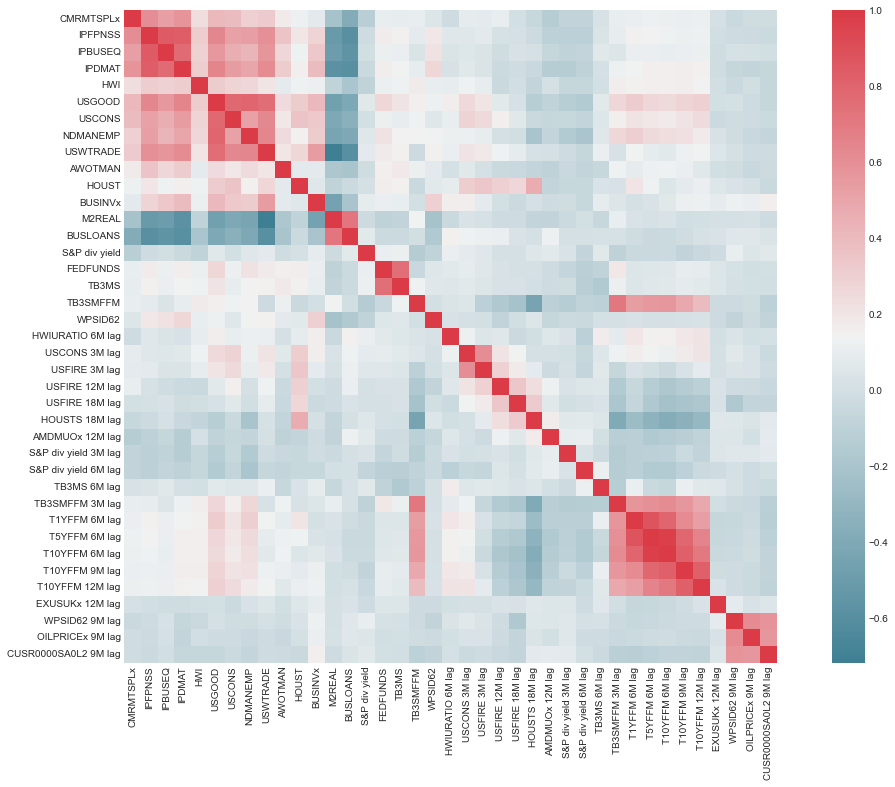

In [163]:
# look at the correlation matrix 
df_reduced_corr = df_reduced.corr()
fig, ax = plt.subplots(1,1,figsize=(20, 12))
sns.heatmap(df_reduced_corr, ax=ax, mask=np.zeros_like(df_reduced_corr, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)
plt.show()

### Training the algorithms:

First of all we create the train set and the test set:

In [164]:
split_1 = "2000-11"
split_2 = "2000-12"
df_train_features = df_reduced[:split_1]
df_test_features  = df_reduced[split_2:]

df_train_targets = df["label"][:split_1]
df_test_targets  = df["label"][split_2:] 

print( df_train_features.shape, df_train_targets.shape )
print( df_test_features.shape, df_test_targets.shape )

(481, 39) (481,)
(255, 39) (255,)


In [165]:
# collect models 
models   = []
models.append( ('LR', LogisticRegression(C=1e09)) )
models.append( ('LR_L1', LogisticRegression(penalty='l1',solver='liblinear')) )
models.append( ('LR_L2', LogisticRegression(penalty='l2')) )
models.append( ('LDA', LinearDiscriminantAnalysis()) )
models.append( ('KNN', KNeighborsClassifier()) )
models.append( ('GB', GradientBoostingClassifier()) )
models.append( ('ABC', AdaBoostClassifier()) )
models.append( ('RF', RandomForestClassifier()) )
models.append( ('XGB', xgb.XGBClassifier()) )

In [166]:
seed     = 8
scoring  = "roc_auc" 
n_splits = 6
kfold    = model_selection.TimeSeriesSplit(n_splits=n_splits) 

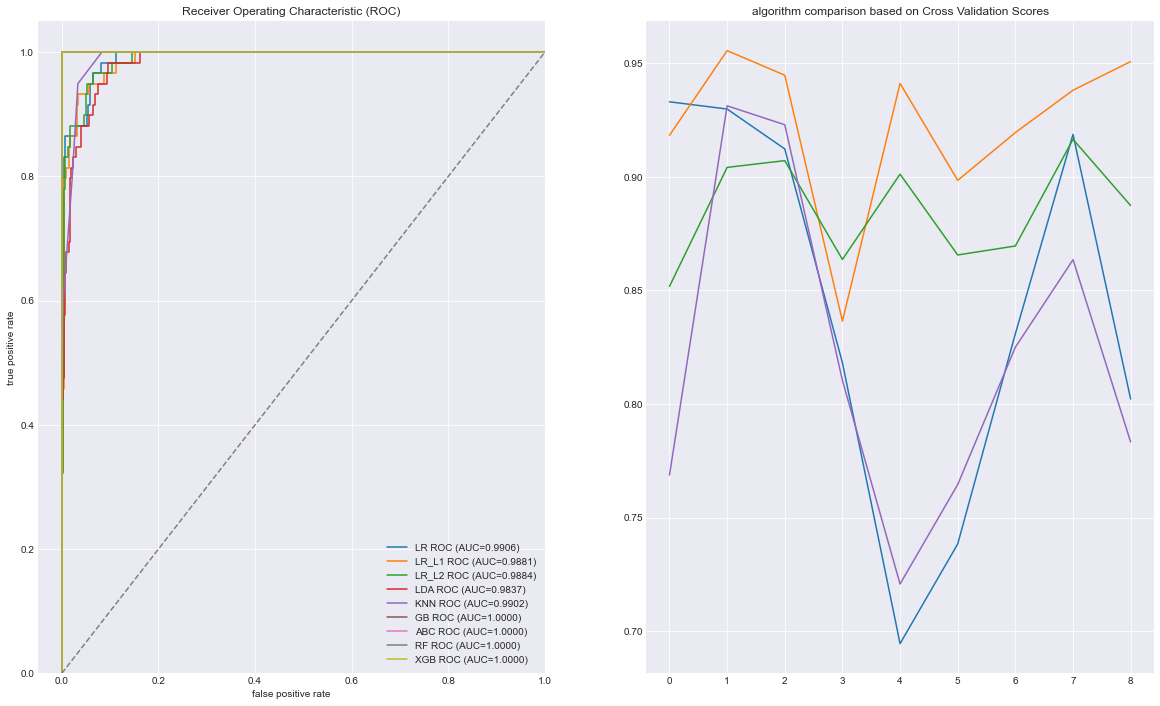

In [171]:
cv_res = []
names  = []

fig, ax = plt.subplots(1,2,figsize=(20,12))
#print("        CV mean CV std")

for name, model in models:
    # train current model
    model.fit(df_train_features, df_train_targets) 
    y_score = model.predict_proba(df_train_features)[:,1]

    # compute roc curve
    fpr, tpr, thresholds = roc_curve(df_train_targets, y_score)
    
    # area under the ROC curve
    auc = roc_auc_score(df_train_targets, y_score)
    
    # cross-validation
    cv_results = model_selection.cross_val_score(estimator=model, cv=kfold, scoring=scoring,
                                                 X = df_train_features, 
                                                 y = LabelBinarizer().fit_transform(df_train_targets)) 

    ax[0].plot(fpr, tpr, label="{} ROC (AUC={:.4f})".format(name,auc) )
    #print( "{}:\t{:.4f}\t({:.4f})".format(name,cv_results.mean(),cv_results.std()))

    cv_res.append(cv_results)
    names.append(name)
    
ax[0].plot([0, 1], [0, 1], color="gray", linestyle="--")
ax[0].set_xlim([-0.05, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('false positive rate')
ax[0].set_ylabel('true positive rate')
ax[0].set_title('Receiver Operating Characteristic (ROC)')
ax[0].legend()
ax[0].grid()

ax[1].plot(cv_res)
#ax[1].set_xticklabels(names)
ax[1].set_title('algorithm comparison based on Cross Validation Scores')
ax[1].grid()

plt.show() 

From the metrics above we can see that Logistic regressions are more accurate that other models. Now lets predict the models on test data and check if logistic regression models outperform others or not.

In [168]:
# dates of normal and recession regimes
df_targets = pd.Series(df_targets, index=df_features.index)
normal_dates     = df_targets[df_targets==0.0].index
recessions_dates = df_targets[df_targets==1.0].index

# find indices of recession regimes 
rec_idx = np.zeros_like(recessions_dates)
rec_idx[0] = 1
for i, date in enumerate(recessions_dates):
    prev_date = date - 1
    if prev_date not in recessions_dates:
        rec_idx[i] = 1
        rec_idx[i-1] = 1
rec_idx = np.array([False if i==0 else True for i in rec_idx])
#recessions_dates[rec_idx]

# index of starting recession periods
x1 = np.array( recessions_dates[rec_idx] )[:-1:2]
# index of ending recession periods
x2 = np.array( recessions_dates[rec_idx] )[1::2]

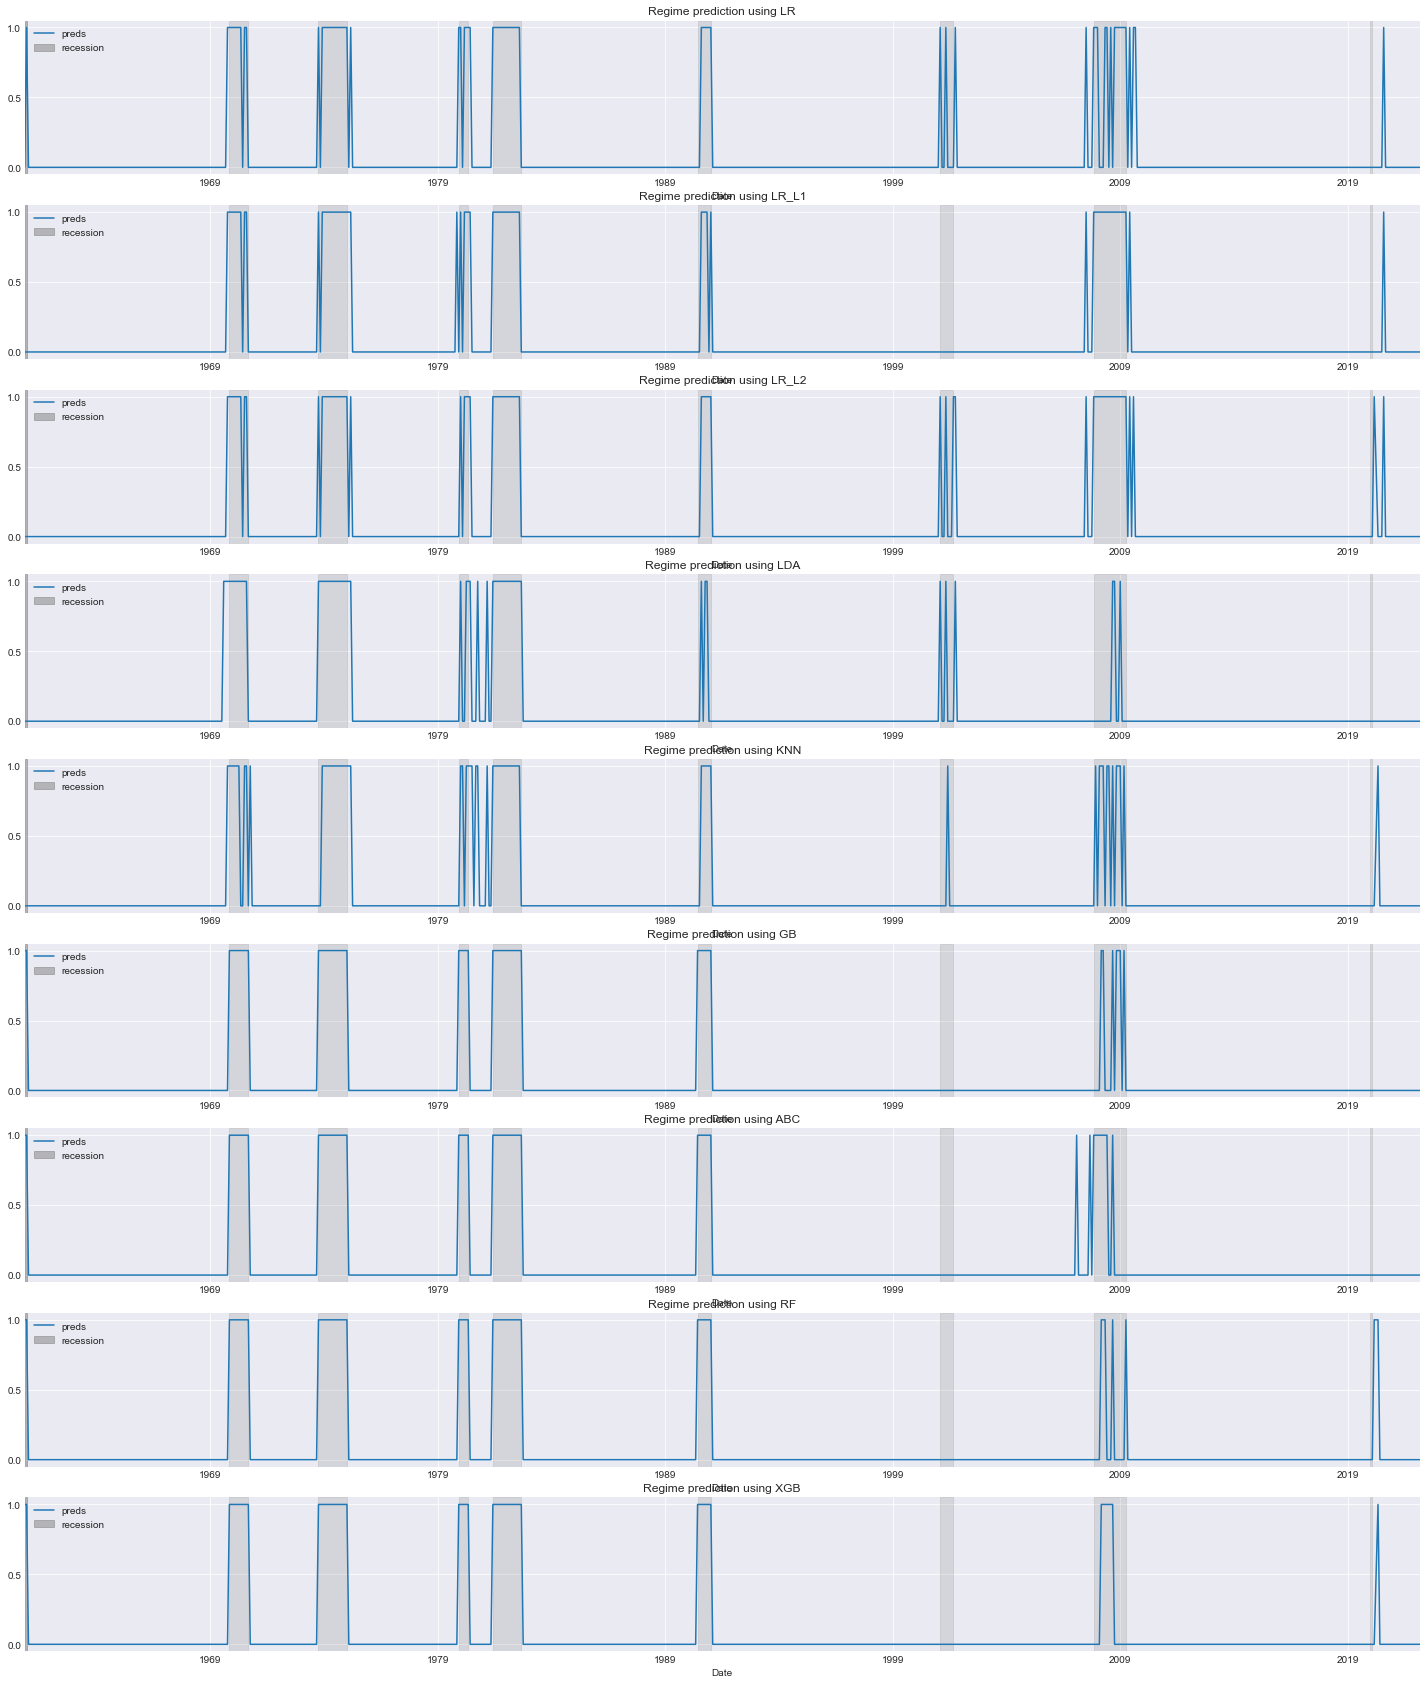

In [172]:
fig, ax = plt.subplots(len(models),1,figsize=(25,30))

for i,model in enumerate(models):
    model_fit = model[1].fit(df_train_features, df_train_targets)

    # prediction on the train set
    train_preds = pd.Series( model_fit.predict(df_train_features), index=df_train_targets.index, name="preds")
    # classes probabilities train set
    train_prob_preds = pd.DataFrame( model_fit.predict_proba(df_train_features), index=df_train_targets.index, columns=["Normal","Recession"])
    train_preds = pd.concat([train_preds, train_prob_preds], axis=1)

    # prediction on the test set
    test_preds = pd.Series( model_fit.predict(df_test_features), index=df_test_targets.index, name="preds")
    # classes probabilities test set
    test_prob_preds = pd.DataFrame( model_fit.predict_proba(df_test_features), index=df_test_targets.index, columns=["Normal","Recession"])
    test_preds  = pd.concat([test_preds, test_prob_preds], axis=1)

    # concat train and test prediction
    total_preds = pd.concat([train_preds,test_preds], axis=0)
    
    # plot
    total_preds["preds"].plot(ax=ax[i], grid=True)
    ax[i].axvspan(x1[0], x2[0], alpha=0.5, color='gray', label="recession")
    for j in range(1,len(x1)):
        ax[i].axvspan(x1[j], x2[j], alpha=0.2, color='gray')
    #ax.axvline(x=300, linestyle="--", color="r")
    ax[i].set_title("Regime prediction using {}".format(model[0]))
    ax[i].legend()
    ax[i].set_yticks([0,0.5,1]) #labels(names)

plt.show()